# Sprint4課題 機械学習スクラッチロジスティック回帰

 ## 【問題1】ロジスティック回帰のクラスを作成する
ロジスティック回帰のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchLogisticRegressionとしてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。推定関係ではラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

[sklearn.linear_model.LinearRegression — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

### シグモイド関数
**コーディング**

シグモイド関数を実装しましょう。

$$
    g(z) = \frac{1}{1+e^{-z}}
$$

正しく動作しているかを確認するために、この関数に-10から10の値を入力したときの出力をプロットしておいてください。



In [36]:
from sklearn.datasets import load_iris
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
sys.path.append("/Users/yusuke-saruya/diveintocode-ml/full-time/diveintocode-term1/ml-scratch/utils/")
import ScratchLogisticRegression

In [37]:
#irisデータセットの読み込み
iris = load_iris()

# 説明変数をPandasのDataFrame型変数Xに格納
X = DataFrame(iris.data, columns = iris.feature_names)

# 目的変数をPandasのDataFrame型変数yに格納し、カラム名を"Species"に変更
y = DataFrame(iris.target, columns = ["Species"])

#X,yを結合させたDataFrame型変数dfを作成
df = pd.concat([X, y], sort=False, axis=1)

"""
<Species>
0:setosa
1:versicolor
2:virginica') 
"""

#setosaとvirgicolorのデータセット
df_extraction = df.query('Species in ["0", "1"]')

#sepal_lengthとpetal_length、Speciesのデータセット
df_extraction = df_extraction.loc[:,['sepal length (cm)', 'sepal width (cm)', 'Species']]

df_extraction.head()

,sepal length (cm),sepal width (cm),Species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0


In [38]:
from sklearn.model_selection import train_test_split

#作成したデータより分割前データを作成する
#ndarrayへ変換を行う
X = df_extraction.loc[:,['sepal length (cm)', 'sepal width (cm)']].values
y = df_extraction.loc[:,['Species']].values

#学習用データ75%、検証データに25%分割する
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.25, random_state=30)

In [39]:
#シグモイド関数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

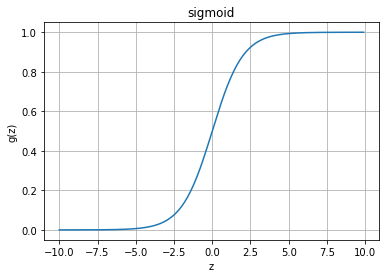

In [40]:
# -10から10の値を生成する
z1 = np.arange(-10,10,0.1)

#シグモイド関数に入力する
sigmoid_z1 = sigmoid(z1)

#プロット図を表示する
plt.plot(z1, sigmoid(z1))
plt.title('sigmoid')
plt.xlabel('z')
plt.ylabel('g(z)')
plt.grid()

### 目的関数
以下の数式で表されるロジスティック回帰の目的関数
J
を実装してください。この数式には正則化項が含まれています。

$$
    h_\theta(x) = g(\theta^T x) \\
    g(z) = \frac{1}{1+e^{-z}} \\
    J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_\theta(x^{(i)})) - (1-y^{(i)})\log(1 - h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2
$$

$m$: 入力されるデータの数

$h_\theta()$ : 仮定関数

$x$ : 特徴量ベクトル

$\theta$ : パラメータベクトル

$g()$ : シグモイド関数

$x(i)$ : i番目のサンプルの特徴量ベクトル

$y(i)$: i番目のサンプルの正解ラベル

$\theta$: j番目のパラメータ（重み）

$n$: 特徴量の数

$\lambda$: 正則化パラメータ





In [41]:
#標準化にする関数
def standardize(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    return (data - mean) / std

In [42]:
#thetaを初期化する
theta = np.random.rand(1,3)

#標準化する
X_train_one = standardize(X_train)

#０列目に1をインサート(x0=1)する
X_train_one = np.insert(X_train_one, 0 ,1, axis=1)

In [43]:
# 仮定関数
def hypothesis(theta, x):
    return sigmoid(np.dot(x, theta.T))

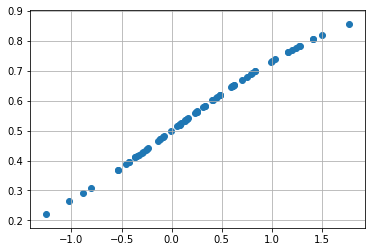

In [44]:
#散布図で確認
plt.scatter(np.dot(X_train_one, theta.T) ,hypothesis(theta, X_train_one))
plt.grid()

In [45]:
def objective(h, y, C=10):
    return (
        ((np.dot(-y.T, np.log(h)) - np.dot((1 - y).T, np.log(1- h))) / len(y_train))
            + (np.sum(theta ** 2) *  C / (2 * len(y_train)))
    )

In [46]:
objective(hypothesis(theta, X_train_one), y_train, C=20)

array([[0.75315924]])

### 最急降下法
最急降下法により学習させてください。バイアス項およびj番目のパラメータの更新には以下の式を使います。

$$
    \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)},\,　j=0　\\
    \frac{\partial J(\theta)}{\partial \theta_j} = (\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m} \theta_j ,\,　j\geq1
$$

In [47]:
# j=0の時の更新式の確認
update_0 = ((np.dot(X_train_one.T, (hypothesis(theta, X_train_one) - y_train))) / len(y_train))[0]
update_0

array([0.08370712])

In [48]:
#j>=1の時の更新式の確認
C=10
update_j = (((np.dot(X_train_one.T, (hypothesis(theta, X_train_one) - y_train))) / len(y_train)) + (((C / len(y_train)) * theta).T))[1:].reshape(-1)
update_j

array([-0.16806059,  0.45394133])

In [49]:
#連結の確認
np.concatenate([update_0, update_j])    

array([ 0.08370712, -0.16806059,  0.45394133])

In [50]:
def gradient_descent(X, y, theta):
    """
    最急降下法にてパラメータを更新する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ

    Returns
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      更新後のパラメータ
    """

    update_0 = ((np.dot(X.T, (hypothesis(theta, X) - y))) / len(y))[0]

    update_j = (((np.dot(X.T, (hypothesis(theta, X) - y))) / len(y)) + (((C / len(y)) * theta).T))[1:].reshape(-1)

    update = np.concatenate([update_0, update_j])

    theta = theta - update

    return theta


In [51]:
#パラメータが更新されているか確認する
theta = np.random.rand(1,3)
for i in range(20):
    theta = gradient_descent(X_train_one, y_train, theta)
    print(theta)

[[ 0.24665974  0.57086312 -0.28312526]]
[[ 0.17371726  0.71220006 -0.4953841 ]]
[[ 0.12217542  0.80114227 -0.62869379]]
[[ 0.08410479  0.85941379 -0.71602402]]
[[ 0.05494382  0.89853151 -0.77495432]]
[[ 0.032022    0.9251705  -0.81552398]]
[[ 0.01367629  0.94345714 -0.84384228]]
[[-0.00119376  0.95605647 -0.86380619]]
[[-0.01335489  0.96474131 -0.87798601]]
[[-0.0233643   0.97071463 -0.88811745]]
[[-0.0316407   0.97480365 -0.89539249]]
[[-0.03850704  0.97758213 -0.90063971]]
[[-0.04421752  0.97945019 -0.90444017]]
[[-0.04897529  0.98068767 -0.90720412]]
[[-0.05294465  0.98149049 -0.90922269]]
[[-0.05625957  0.98199576 -0.91070337]]
[[-0.05903008  0.98229922 -0.91179454]]
[[-0.06134693  0.98246755 -0.91260264]]
[[-0.06328529  0.98254695 -0.91320426]]
[[-0.06490755  0.98256923 -0.91365467]]


### クラスにまとめる

In [52]:
from sklearn.datasets import load_iris
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy import integrate
import pickle

class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    C : int
        正則化パラメータ(デフォルト値10)

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter, lr, no_bias, verbose, C=10):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter                            #イテレーション数
        self.lr = lr                                             #学習率
        self.no_bias = no_bias                      #True:バイアス項なし、　False:バイアス項あり
        self.verbose = verbose                     #True:表示、False:非表示
        self.C = C                                            #正則化パラメータ（デフォルト値10）
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
        
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
            
        Returns
        -------
        self : returns an instance of self.            
            
        """
        #pandasをnp.arrayに変換
        X = np.array(X)
        y = np.array(y)
        
        #学習データが一次元の場合、次元変換する
        if X.ndim == 1:
            X = X.reshape(len(X), 1)
        
        #バイアス項を含める場合は、
        if self.no_bias is False:
            #x0（全て1）を０列目に挿入する
            X_0 = np.insert(X, 0, 1, axis=1)
        #バイアス項を入れない場合、0を挿入する
        else:
            X_0 = np.insert(X, 0, 0, axis=1)

        #n(特徴量の数+1)を算出
        n = X_0.shape[1]

        # パラメータの初期化
        self.coef_ = np.random.rand(1, n)
                
        #イテレーションの数だけパラメータを更新する
        for i in range(self.iter):

            #仮定関数を求める
            hypothesis = self._linear_hypothesis(X_0)
            
            error = hypothesis - y

            # 損失関数
            cost_function = self.objective(hypothesis, y)
            
            #損失関数を記録する
            self.loss[i] = cost_function
            
            #最後の一回はパラメータ更新なし
            if i <= self.iter - 2:
                #最急降下法によりパラメータ更新
                self.coef_ = self._gradient_descent(X_0, error)
                
                #　一時的に学習したパラメータを退避（検証データで学習された際に元に戻す）
                tmp_coef_ = self.coef_

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
                map_result = map(str, self.loss)
                result = ',\n'.join(map_result)                
                print('学習データ　目的関数 : \n{}'.format(result))
                
        if X_val is not None:
            #pandasをnp.arrayに変換
            X_val = np.array(X_val)
            y_val = np.array(y_val)
            
            #学習データが一次元の場合、次元変換する
            if X_val.ndim == 1:
                X_val = X_val.reshape(len(X_val), 1)

            #バイアス項を含める場合は、
            if self.no_bias is False:
                #x0（全て1）を０列目に挿入する
                X_val_0 = np.insert(X_val, 0, 1, axis=1)
            #バイアス項を入れない場合、0を挿入する
            else:
                X_val_0 = np.insert(X_val, 0, 0, axis=1)

            #n(特徴量の数+1)を算出
            n = X_val_0.shape[1]

            # パラメータの初期化
            self.coef_ = np.random.rand(1, n)

            m = len(X_val_0)

            #イテレーションの数だけパラメータを更新する
            for i in range(self.iter):

                #仮定関数を求める
                hypothesis_val = self._linear_hypothesis(X_val_0)

                error_val = hypothesis_val - y_val

                # 損失関数
                cost_function_val = self.objective(hypothesis_val, y_val)

                #損失関数を記録する
                self.val_loss[i] = cost_function_val

                #最後の一回はパラメータ更新なし
                if i <= self.iter - 2:
                    #最急降下法によりパラメータ更新
                    self.coef_ = self._gradient_descent(X_val_0, error_val)

            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                map_result = map(str, self.val_loss)
                result = ',\n'.join(map_result)                
                print('検証データ　目的関数 : \n{}'.format(result))
        
        self.coef_ = tmp_coef_
    

    def predict(self, X):
        """
        ロジスティック回帰を使い分類する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による分類結果
            (予測確率が0.5以上であれば、1を返す)
        """
        #学習データが一次元の場合、次元変換する
        if X.ndim == 1:
            X = X.reshape(len(X), 1)
        
        #バイアス項を含める場合は、
        if self.no_bias is False:
            #x0（全て1）を０列目に挿入する
            X_0 = np.insert(X, 0, 1, axis=1)
        #バイアス項を入れない場合、0を挿入する
        else:
            X_0 = np.insert(X, 0, 0, axis=1)

        return (self._linear_hypothesis(X_0)>=0.5).astype(np.int)
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い分類する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape [n_samples, n_classes]
            ロジスティック回帰による分類結果
        """
        #学習データが一次元の場合、次元変換する
        if X.ndim == 1:
            X = X.reshape(len(X), 1)
        
        #バイアス項を含める場合は、
        if self.no_bias is False:
            #x0（全て1）を０列目に挿入する
            X_0 = np.insert(X, 0, 1, axis=1)
        #バイアス項を入れない場合、0を挿入する
        else:
            X_0 =np.insert(X, 0, 0, axis=1)
        
        classes0 = 1- self._linear_hypothesis(X_0)
        classes1 = self._linear_hypothesis(X_0)
        
        return np.concatenate([classes0, classes1], 1)
    
    
    #シグモイド関数
    def _sigmoid(self, z):
        """
        ロジスティック回帰のシグモイド関数を計算する

        Parameters
        ----------
        z : 次の形のndarray, shape (n_samples, 1)
          学習データ

        Returns
        -------
        sigmoid : 次の形のndarray, shape (n_samples, 1)
          入力値からシグモイド関数の結果を返す

        """        
        return 1 / (1 + np.exp(-z))        
        
        
        
    def _linear_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          仮定関数による推定結果

        """
        #仮定関数を求める
        return self._sigmoid(np.dot(X, self.coef_.T))
    

    def objective(self, y_pred, y):
    
        """
        目的関数の計算

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
        objective : numpy.float
          目的関数の結果
        """    
        return (
            ((np.dot(-y.T, np.log(y_pred)) - np.dot((1 - y).T, np.log(1- y_pred))) / len(y))
                + (np.sum(theta ** 2) *  self.C / (2 * len(y)))
        )
    
    def _gradient_descent(self, X, error):
        """
        最急降下法にてパラメータを更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        error : 次の形のndarray, shape (n_samples,)
          仮定関数から目的関数を差し引いたもの

        Returns
        ----------
        self.coef_ : 次の形のndarray, shape (n_features,)
          更新後のパラメータ
        """

        update_0 = ((np.dot(X.T, error)) / len(y))[0]

        update_j = (((np.dot(X.T, error)) / len(y)) + (((self.C / len(y)) * self.coef_).T))[1:].reshape(-1)

        update = np.concatenate([update_0, update_j])

        self.coef_ = self.coef_ - self.lr * update

        return self.coef_
    
    #学習曲線を表示する
    def plot_learning_curve(self):
        """
        学習曲線を表示する

        Parameters
        ----------

        Returns
        ----------
        学習時における損失の推移をプロットする
        fit時に検証データが入力されている場合、val_lossもプロットする
        """
        #trainデータの学習曲線を表示する
        plt.plot(self.loss, label='train_loss')
        
        #valデータが入力されている場合、表示する
        if np.all(self.val_loss!=0):
            plt.plot(self.val_loss, label='val_loss')

        plt.title('Learning curve')
        plt.xlabel('iter')
        plt.ylabel('loss')
        plt.legend()

        plt.show()

        
    #混同行列を計算する    
    def confusion_matrix(self, y_true, y_pred):
        """
        予測値より混同行列を計算する

        Parameters
        ----------
        y_true : 次の形のndarray, shape (n_samples,)
          正解値
        y_pred : 次の形のndarray, shape (n_samples,)
          予測値

        Returns
        ----------
        confusion_matrix : 次の形のndarray, shape (n_classes,n_classes)
          正解値と予測値における混同行列
        """
        #正解値と予測値を結合する
        y_true_and_pred = np.concatenate([y_true, y_pred], 1)

        # 目的変数でのユニークな要素をリスト化
        class_list = np.unique(y_true_and_pred)

        #クラスの数を数える
        n_classes = len(class_list)

        #クラスの数だけ空のの混同行列を作成
        c_matrix = np.zeros([n_classes,n_classes])

        #正解値と予測値の結果に応じて、混同行列を更新する
        for row, class1 in enumerate(class_list):
            for column, class2 in enumerate(class_list):
                for i in range(len(y_true)):
                    if (y_true[i] == class_list[class1]) and (y_pred[i] == class_list[class2]):
                        c_matrix[row][column] += 1
                
        return c_matrix

    
    def accuracy_score(self, y_true, y_pred):
        """
        予測値より正解率(accuracy)を計算する

        Parameters
        ----------
        y_true : 次の形のndarray, shape (n_samples,)
          正解値
        y_pred : 次の形のndarray, shape (n_samples,)
          予測値

        Returns
        ----------
        accuracy_score : float
          正解値と予測値における正解率(Accuracy)
        """
        
        #混同行列を算出
        conf_mat = self.confusion_matrix(y_true, y_pred)
        
        #混同行列の合計を算出
        sumconf = np.sum(conf_mat)
        
        #TP+TNを計算する
        tp_tn = 0
        for i in range(len(conf_mat)):
            tp_tn += conf_mat[i][i]

        #accuracy_scoreを算出
        return tp_tn / sumconf

    def precision_score(self, y_true, y_pred):
        """
        予測値より精度(precision)を計算する
        ※二値分類のみ対応

        Parameters
        ----------
        y_true : 次の形のndarray, shape (n_samples,)
          正解値
        y_pred : 次の形のndarray, shape (n_samples,)
          予測値

        Returns
        ----------
        precision_score : float
          正解値と予測値における精度(Precision)
        """
        
        #混同行列を算出
        conf_mat = self.confusion_matrix(y_true, y_pred)
        
        #TP+FPを計算
        tp_fp = 0
        for i in range(len(conf_mat)):
            tp_fp += conf_mat[i][0]
            
        #TPをセット
        tp = conf_mat[0][0]
        
        #precisionを算出
        return tp / tp_fp
    

    def recall_score(self, y_true, y_pred):
        """
        予測値より検出率(recall)を計算する
        ※二値分類のみ対応

        Parameters
        ----------
        y_true : 次の形のndarray, shape (n_samples,)
          正解値
        y_pred : 次の形のndarray, shape (n_samples,)
          予測値

        Returns
        ----------
        recall_score : float
          正解値と予測値における検出率(Recall)
        """
        
        #混同行列を算出
        conf_mat = self.confusion_matrix(y_true, y_pred)
        
        #TP+FNを計算
        tp_fn = 0
        for i in range(len(conf_mat)):
            tp_fn += conf_mat[0][i]
            
        #TPをセット
        tp = conf_mat[0][0]
        
        #recallを算出
        return tp / tp_fn



    def f1_score(self, y_true, y_pred):
        """
        予測値よりF値を計算する
        ※二値分類のみ対応
        F1 = 2 * (precision * recall) / (precision + recall)

        Parameters
        ----------
        y_true : 次の形のndarray, shape (n_samples,)
          正解値
        y_pred : 次の形のndarray, shape (n_samples,)
          予測値

        Returns
        ----------
        recall_score : float
          正解値と予測値における検出率(Recall)
        """
        #精度を計算        
        precision = self.precision_score(y_true, y_pred)
        
        #検出率を計算
        recall = self.recall_score(y_true, y_pred)
               
        #F値を計算する
        return 2 * (precision * recall) / (precision + recall)
    

    def decision_region(self, X_train, y_train, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
        """
        2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
        背景の色が学習したモデルによる推定値から描画される。
        散布図の点は学習用データである。

        Parameters
        ----------------
        X_train : ndarray, shape(n_samples, 2)
            学習用データの特徴量
        y_train : ndarray, shape(n_samples,)
            学習用データの正解値
        step : float, (default : 0.1)
            推定値を計算する間隔を設定する
        title : str
            グラフのタイトルの文章を与える
        xlabel, ylabel : str
            軸ラベルの文章を与える
        target_names= : list of str
            凡例の一覧を与える
        """
        # setting
        scatter_color = ['red', 'blue']
        contourf_color = ['pink', 'skyblue']
        n_class = 2

        # pred
        mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
        mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
        pred = self.predict(mesh).reshape(mesh_f0.shape)

        # plot
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
        plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
        for i, target in enumerate(set(y_train)):
            plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
        patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
        plt.legend(handles=patches)
        plt.legend()
        plt.show()



In [57]:
#作成したクラスにてインスタンス生成
slr = ScratchLogisticRegression(num_iter=100, lr=0.1, no_bias=False, verbose=True, C=10)

In [58]:
#標準化する
X_train_std = standardize(X_train)
X_validation_std = standardize(X_validation)

In [59]:
#trainデータにて学習を行う（学習履歴を表示する）
slr.fit(X_train_std, y_train, X_validation_std, y_validation)

学習データ　目的関数 : 
0.8882132280972452,
0.8677190380116608,
0.8480797882746716,
0.8292675933259874,
0.8112546187875486,
0.7940131444956134,
0.7775156268990249,
0.7617347604805663,
0.7466435377844965,
0.7322153075738705,
0.718423830602782,
0.7052433324750174,
0.6926485530729214,
0.680614792077424,
0.6691179501590914,
0.6581345654964853,
0.6476418453668968,
0.6376176926503523,
0.6280407271854707,
0.6188903020106167,
0.6101465146119301,
0.6017902133781852,
0.5938029995289422,
0.5861672248359063,
0.5788659854974257,
0.5718831125529513,
0.5652031592389077,
0.5588113856910398,
0.5526937413924007,
0.5468368457523801,
0.5412279671821736,
0.5358550010074461,
0.5307064465311194,
0.5257713835294853,
0.5210394484343431,
0.5165008104234706,
0.5121461476122138,
0.5079666235108552,
0.5039538638860938,
0.500099934140708,
0.49639731730341063,
0.4928388927011047,
0.48941791536818313,
0.48612799623212044,
0.4829630831012515,
0.4799174424691938,
0.4769856421406812,
0.47416253467547737,
0.471443241640359,
0.4688

In [60]:
#検証用データにて予測する
y_val_pred = slr.predict(X_validation_std)
y_val_pred

array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [61]:
#検証用データにて種類ごとに予測した確率をだす
y_val_proba = slr.predict_proba(X_validation_std)
y_val_proba

array([[0.6927587 , 0.3072413 ],
       [0.28983728, 0.71016272],
       [0.72782405, 0.27217595],
       [0.13581473, 0.86418527],
       [0.79141805, 0.20858195],
       [0.18233429, 0.81766571],
       [0.85521815, 0.14478185],
       [0.45322519, 0.54677481],
       [0.24566439, 0.75433561],
       [0.28038561, 0.71961439],
       [0.26717114, 0.73282886],
       [0.81947813, 0.18052187],
       [0.80494394, 0.19505606],
       [0.14850104, 0.85149896],
       [0.86662695, 0.13337305],
       [0.26717114, 0.73282886],
       [0.07781217, 0.92218783],
       [0.23355521, 0.76644479],
       [0.81648585, 0.18351415],
       [0.79429511, 0.20570489],
       [0.3560234 , 0.6439766 ],
       [0.850498  , 0.149502  ],
       [0.27634842, 0.72365158],
       [0.11143245, 0.88856755],
       [0.69089124, 0.30910876]])

## 【問題2】学習曲線のプロット
学習曲線をプロットしてください。

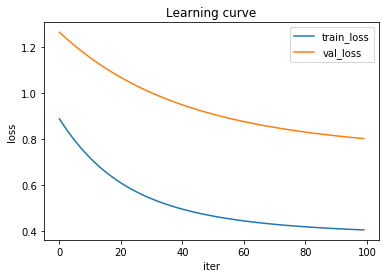

In [62]:
#学習曲線をプロットする
slr.plot_learning_curve()

## 【問題3】指標値の算出
分類に関する指標値で精度を確認してください。

In [63]:
#混同行列を表示
conf_mat = slr.confusion_matrix(y_validation, y_val_pred)
conf_mat

array([[11.,  0.],
       [ 0., 14.]])

In [64]:
#正解率（Accuracy）を算出
print('Accuracy : {}'.format(slr.accuracy_score(y_validation, y_val_pred)))

Accuracy : 1.0


In [65]:
#精度（Precision）を算出
print('Precision : {}'.format(slr.precision_score(y_validation, y_val_pred)))

Precision : 1.0


In [66]:
#検出率（Recall）を算出
print('Recall : {}'.format(slr.recall_score(y_validation, y_val_pred)))

Recall : 1.0


In [67]:
#F値を算出
print('F1: {}'.format(slr.f1_score(y_validation, y_val_pred)))

F1: 1.0


## 【問題4】決定領域の可視化
2値分類のデータセットに対して決定領域を可視化してください。

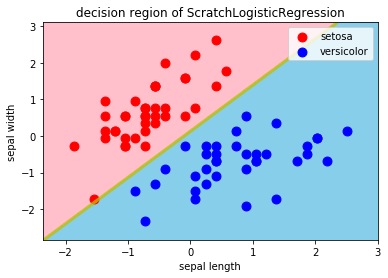

In [68]:
'''
決定領域をプロットする
'''
slr.decision_region(
    X_train=X_train_std, #標準化データを利用する
    y_train=y_train.reshape(-1),   #set型に対応するために一次元配列にする
    title='decision region of ScratchLogisticRegression', 
    xlabel='sepal length', 
    ylabel='sepal width', 
    target_names=['setosa', 'versicolor']
)


## 【問題5】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやnumpy.savezを利用します。

[pickle — Python オブジェクトの直列化 — Python 3.7.1 ドキュメント](https://docs.python.org/ja/3/library/pickle.html)

[numpy.savez — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.savez.html#numpy.savez)

### pyファイル化を行う(classify_pipeline.py)

In [99]:
#pyファイル格納ディレクトリのパス設定
import sys
sys.path.append("/Users/yusuke-saruya/diveintocode-ml/full-time/diveintocode-term1/ml-scratch/utils/")
import classify_pipeline

In [100]:
#pyファイルよりインスタンス生成
slr2 = classify_pipeline.ScratchLogisticRegression(num_iter=500, lr=0.1, no_bias=False, verbose=False, C=10)

In [101]:
#学習を行う
slr2.fit(X=X_train_std, y=y_train, X_val=X_validation_std, y_val=y_validation)

In [102]:
#パラメータ確認
slr2.coef_

array([[-0.07307737,  0.98201793, -0.91514617]])

### pickleモジュール

In [103]:
#pickleモジュールを用いてモデルを保存する
with open('slr.pickle', 'wb') as f:
    pickle.dump(slr2, f)

In [104]:
#pickleモジュールを用いてモデルを読み込む
with open('slr.pickle', 'rb') as f:
    slr2_pickle = pickle.load(f)

In [105]:
#パラメータの確認
slr2_pickle.coef_

array([[-0.07307737,  0.98201793, -0.91514617]])

### numpy.savez

In [106]:
#pyファイルよりインスタンス生成
slr3 = classify_pipeline.ScratchLogisticRegression(num_iter=10, lr=0.1, no_bias=False, verbose=False, C=10)

#学習を行う
slr3.fit(X=X_train_std, y=y_train, X_val=X_validation_std, y_val=y_validation)

#パラメータ確認
slr3.coef_

array([[ 0.5664404 ,  0.29768089, -0.00880927]])

In [107]:
#２種類のパラメータを保存する
np.savez('slr.npz', x=slr2.coef_, y=slr3.coef_)

In [108]:
#ロードする
slr_load = np.load('slr.npz')

In [109]:
#1種類めのパラメータ表示
print(slr_load['x'])

[[-0.07307737  0.98201793 -0.91514617]]


In [110]:
#2種類めのパラメータ表示
print(slr_load['y'])

[[ 0.5664404   0.29768089 -0.00880927]]


## 【問題6】分類と回帰
最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

- 分類問題と回帰問題は本質的に何が異なっているか

**注意点**

答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

|<index>|分類問題|回帰問題|
|:-:|:-:|:-:|
|予測の対象 |データが属するクラス|連続値などの値 |
|求める線の種類<br>(直線の場合) |重みベクトルを法線<br>ベクトルとする直線|一次関数 |
